In [1]:
import logging

import numpy as np
import probtorch
import torch

import dynamical_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [8]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [9]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [10]:
def accumulate_trajectory(inference):
    result = torch.zeros(*num_particles, len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value
    return result

In [11]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [12]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [13]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [14]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [15]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [16]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [17]:
def training_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    initializer = combinators.GuidedConditioning(init_bouncing_ball, init_proposal)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    step = combinators.GuidedConditioning(bouncing_ball_step, step_proposal)
    return foldable.Reduce(foldable.Foldable(step, initializer=initializer), lambda: range(T))

In [18]:
def posterior_model(trained_init, trained_step):
    return mcmc.reduce_resample_move_smc(trained_step, lambda: range(T), initializer=trained_init, moves=5)

02/13/2019 16:32:08 ELBO=-9.36712830e+02 at epoch 1
02/13/2019 16:32:08 ELBO=-1.52091760e+03 at epoch 2
02/13/2019 16:32:08 ELBO=-1.03539783e+03 at epoch 3
02/13/2019 16:32:08 ELBO=-9.16670044e+02 at epoch 4
02/13/2019 16:32:09 ELBO=-1.14308337e+03 at epoch 5
02/13/2019 16:32:09 ELBO=-1.30675745e+03 at epoch 6
02/13/2019 16:32:09 ELBO=-9.40392273e+02 at epoch 7
02/13/2019 16:32:09 ELBO=-9.67363770e+02 at epoch 8
02/13/2019 16:32:09 ELBO=-1.05800635e+03 at epoch 9
02/13/2019 16:32:10 ELBO=-8.93310242e+02 at epoch 10
02/13/2019 16:32:10 ELBO=-9.43562378e+02 at epoch 11
02/13/2019 16:32:10 ELBO=-1.32756409e+03 at epoch 12
02/13/2019 16:32:10 ELBO=-1.17378162e+03 at epoch 13
02/13/2019 16:32:10 ELBO=-1.21217590e+03 at epoch 14
02/13/2019 16:32:11 ELBO=-1.36636279e+03 at epoch 15
02/13/2019 16:32:11 ELBO=-1.12118005e+03 at epoch 16
02/13/2019 16:32:11 ELBO=-8.98493103e+02 at epoch 17
02/13/2019 16:32:11 ELBO=-1.02911243e+03 at epoch 18
02/13/2019 16:32:12 ELBO=-1.27224475e+03 at epoch 19
02

Epoch   921: reducing learning rate of group 0 to 5.0000e-02.


02/13/2019 16:35:31 ELBO=-5.46764404e+02 at epoch 924
02/13/2019 16:35:31 ELBO=-5.93335083e+02 at epoch 925
02/13/2019 16:35:31 ELBO=-5.71369629e+02 at epoch 926
02/13/2019 16:35:32 ELBO=-5.82320190e+02 at epoch 927
02/13/2019 16:35:32 ELBO=-5.56387329e+02 at epoch 928
02/13/2019 16:35:32 ELBO=-5.43187500e+02 at epoch 929
02/13/2019 16:35:32 ELBO=-5.11008392e+02 at epoch 930
02/13/2019 16:35:32 ELBO=-5.34820312e+02 at epoch 931
02/13/2019 16:35:33 ELBO=-5.31839478e+02 at epoch 932
02/13/2019 16:35:33 ELBO=-5.09688141e+02 at epoch 933
02/13/2019 16:35:33 ELBO=-5.26351379e+02 at epoch 934
02/13/2019 16:35:33 ELBO=-5.44557617e+02 at epoch 935
02/13/2019 16:35:33 ELBO=-5.24013794e+02 at epoch 936
02/13/2019 16:35:34 ELBO=-5.27086731e+02 at epoch 937
02/13/2019 16:35:34 ELBO=-5.46868164e+02 at epoch 938
02/13/2019 16:35:34 ELBO=-5.40081604e+02 at epoch 939
02/13/2019 16:35:34 ELBO=-5.75355530e+02 at epoch 940
02/13/2019 16:35:34 ELBO=-5.05922668e+02 at epoch 941
02/13/2019 16:35:35 ELBO=-5.

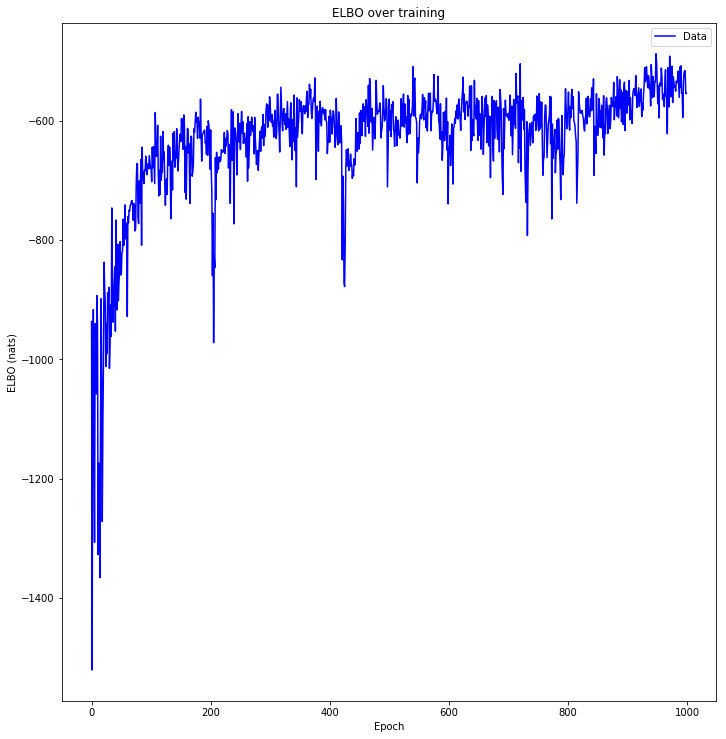

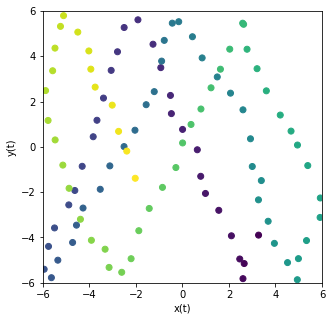

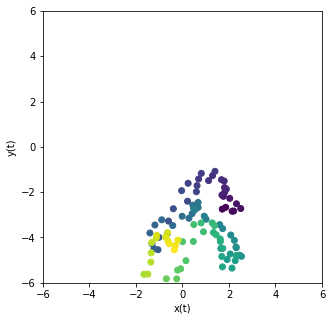

In [19]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=200,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = posterior_model(importance_sampler.folder._initializer, importance_sampler.folder.operator)
    (boundary, dynamics, uncertainty, noise, position), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [20]:
trained_params

"{'boundary__loc': 'tensor(0.1570, grad_fn=<CloneBackward>)', 'boundary__scale': 'tensor(0.8958, grad_fn=<CloneBackward>)', 'dynamics__loc': 'tensor([[ 0.0143, -0.0070],\n        [ 0.0122, -0.0347]], grad_fn=<CloneBackward>)', 'dynamics__scale': 'tensor([[-3.6035, -3.6020],\n        [-3.4438, -3.3471]], grad_fn=<CloneBackward>)', 'noise__loc': 'tensor([0.6862, 0.9420], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.0990, -2.1520], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.1132,  0.0000],\n        [-0.7773,  0.3681]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([ 1.6267, -1.5860], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-0.8961, -0.4958], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-1.3397, -1.7338], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 0.1611, -0.8917],\n        [ 0.0695, -0.5775],\n        [-0.0494, -0.1177],\n        [-0.2101,  0.2107],\n        [-0.2688,  0.4018],\n        [-0.2839,  0

In [21]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([ 3.2738, -3.8947])
Position at time 1 tensor([ 2.6559, -5.1499])
Position at time 2 tensor([ 2.6032, -5.8166])
Position at time 3 tensor([ 2.4645, -4.9491])
Position at time 4 tensor([ 2.1060, -3.9248])
Position at time 5 tensor([ 1.5625, -2.7999])
Position at time 6 tensor([ 0.9900, -2.0551])
Position at time 7 tensor([ 0.7854, -1.2979])
Position at time 8 tensor([ 0.6392, -0.1265])
Position at time 9 tensor([0.0053, 0.7720])
Position at time 10 tensor([-0.4757,  1.4696])
Position at time 11 tensor([-0.5156,  2.2723])
Position at time 12 tensor([-0.9314,  3.4995])
Position at time 13 tensor([-1.2664,  4.5333])
Position at time 14 tensor([-1.9144,  5.6114])
Position at time 15 tensor([-2.5074,  5.2711])
Position at time 16 tensor([-2.7936,  4.2002])
Position at time 17 tensor([-3.0656,  3.3786])
Position at time 18 tensor([-3.3967,  2.1556])
Position at time 19 tensor([-3.6765,  1.1761])
Position at time 20 tensor([-3.8386,  0.4488])
Position at time 21 tenso

In [22]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([ 1.7126, -2.7477])
Inferred position at time 1 tensor([ 1.8615, -2.6665])
Inferred position at time 2 tensor([ 2.1383, -2.8404])
Inferred position at time 3 tensor([ 2.2036, -2.8297])
Inferred position at time 4 tensor([ 2.5090, -2.7196])
Inferred position at time 5 tensor([ 2.3239, -2.5116])
Inferred position at time 6 tensor([ 2.0351, -2.2715])
Inferred position at time 7 tensor([ 1.7604, -2.1828])
Inferred position at time 8 tensor([ 1.8134, -2.0078])
Inferred position at time 9 tensor([ 1.6967, -2.1249])
Inferred position at time 10 tensor([ 1.8100, -1.7958])
Inferred position at time 11 tensor([ 1.8887, -1.8597])
Inferred position at time 12 tensor([ 1.7948, -1.5087])
Inferred position at time 13 tensor([ 1.6799, -1.4481])
Inferred position at time 14 tensor([ 1.2947, -1.2679])
Inferred position at time 15 tensor([ 1.1263, -1.4879])
Inferred position at time 16 tensor([ 0.6954, -1.4167])
Inferred position at time 17 tensor([ 1.3988, -1.0790])
In